In [11]:
from importlib import reload
from time import time 

import numpy as np
import scipy as sc
import pandas as pd
import torch
 
import gb1
import models
from utils import str2onehot, DEFAULT_GMM_QS

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('whitegrid')

# Load ground-truth labels for all sequences $x \in \mathcal{X}$

Don't need to run this cell for algorithm selection experiments below, just to visualize and get a sense of the labels

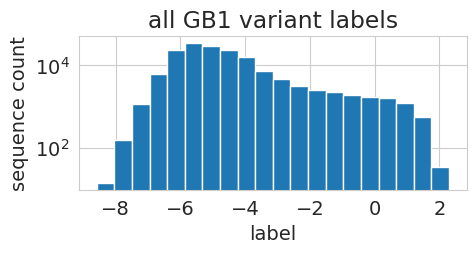

In [3]:
# gb1.SEQ2YVAR maps every possible length-4 amino acid sequence to a list of two floats,
# the sequence's measured log enrichment and the estimated variance of the enrichment
# (latter used for training the model)
y_n = np.array([y for y, var in gb1.SEQ2YVAR.values()])
plt.figure(figsize=(5, 2))
plt.hist(y_n, bins=20, log=True);
plt.xlabel('label');
plt.ylabel('sequence count');
plt.title('all GB1 variant labels');

# Load predictive models and menu

Load predictive models and visualize predictions for all sequences $x \in \mathcal{X}$.

In [4]:
# load predictive model (ensemble of feedforward models) trained on 5k labeled sequences,
# used by PP (our method) and CalibratedForecasts method
model_5k = models.EnrichmentFeedForward(
    4,
    gb1.AA,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model_5k.load('gb1-models/gb1-5k-model.pt')

# load predictive model trained on 10k labeled sequences,
# used by prediction-only and GMMForecasts methods
model_10k = models.FeedForward(
    seq_len=4,
    alphabet=gb1.AA,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model_10k.load('gb1-models/gb1-10k-model.pt')

Load design distributions corresponding to each temperature on the menu.

In the cell below, temp2theta_* is a dictionary that maps real-valued temperature to the corresponding design distribution, which is parameterized by a (seq_len X 4) matrix, theta_lxa.
Each row of theta_lxa gives the logits of a categorical distribution over the 4 nucleotides at a site. There are a total of seq_len nucleotide sites, where seq_len = (# protein residues) * 3 = 12 because (# protein residues) = 4 for this dataset and there are 3 nucleotides per codon.
temp2theta_5k contains the design distributions ($q_\lambda$ in the main paper) solved for with the 5k-trained model above, and temp2theta_10k contains the design distributions solved for with the 10k-trained model.

In [5]:
# all candidate temperatures on the menu
temperatures = np.arange(0.2, 0.701, 0.005)

temp2theta_5k = {
    round(temp, 4): np.load('gb1-models/5k-t{:.4f}.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
# compute true mean design label for each temperature on the menu
temp2mean_5k = gb1.get_true_mean_label_from_theta(temp2theta_5k)

temp2theta_10k = {
    round(temp, 4): np.load('gb1-models/10k-t{:.4f}.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
# compute true mean design label for each temperature on the menu
temp2mean_10k = gb1.get_true_mean_label_from_theta(temp2theta_10k) 

/homefs/home/wongfanc/density-ratio-estimation/gb1.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  paa_axl[cod_site + 1].loc[aa] += p_cod


# Demo: sample sequences from a temperature on the menu

Don't need to run this cell to run algorithm selection experiments (skip to next cell); this is just a demo of how to sample sequences from the design distribution corresponding to a temperature on the menu.

Sampled 10000 design sequences for temperature 0.500 (0 s).

Example design sequences:
['lcca', 'fcaa', 'vlga', 'icaa', 'lcga', 'viga', 'ilaa', 'flaa', 'lfag', 'vpga']
True mean label of this design distribution: 0.577.

Sampled 10000 training sequences from NNK library (0 s).

Example training distribution sequences:
['awgy', 'evvp', 'hyta', 'scpp', 'ivpa', 'fwva', 'grvd', 'qpsl', 'lpya', 'shmv']


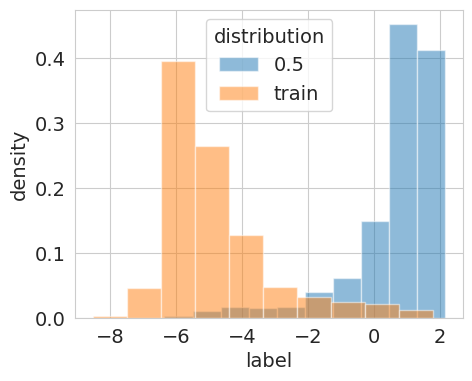

In [8]:
temp = 0.5 # temperature of interest
n_sample = 10000 # desired number of samples

# fetch categorical distribution parameters theta_lxa corresponding to this temperature
theta_lxa = temp2theta_5k[round(temp, 4)]

# ===== Sample from this design distribution =====
# i-th element of designohe_nxlxa is the one-hot-encoded (seq_len x alphabet_size) = (4 x 20)
# representation of the i-th element of designseq_n, which is the length-4 sequence as a str.
t0 = time()
_, designohe_nxlxa, designseq_n = gb1.sample_ohe_from_nuc_distribution(
    theta_lxa, n_sample, normalize=True, reject_stop_codon=True
)
print('Sampled {} design sequences for temperature {:.3f} ({} s).\n'.format(
    n_sample, temp, int(time() - t0)
))
print('Example design sequences:')
print(designseq_n[: 10])
print('True mean label of this design distribution: {:.3f}.\n'.format(temp2mean_5k[round(temp, 4)]))

# get true labels of design sequences
ydesign_n = np.array([gb1.SEQ2YVAR[seq][0] for seq in designseq_n])

# ===== Sample from training distribution, for comparison =====
_, trainohe_nxlxa, trainseq_n = gb1.sample_ohe_from_nuc_distribution(
    gb1.PNUC_NNK_LXA, n_sample, normalize=False, reject_stop_codon=True
)
print('Sampled {} training sequences from NNK library ({} s).\n'.format(n_sample, int(time() - t0)))
print('Example training distribution sequences:')
print(trainseq_n[: 10])

# get true labels of train sequences
ytrain_n = np.array([gb1.SEQ2YVAR[seq][0] for seq in trainseq_n])

# ===== plot histograms of training labels and design labels, for comparison =====
plt.figure(figsize=(5, 4))
plt.hist(ydesign_n, density=True, alpha=0.5, label=temp)
plt.hist(ytrain_n, density=True, alpha=0.5, label='train')
plt.xlabel('label');
plt.ylabel('density')
plt.legend(title='distribution'); 

# Run temperature selection experiments

In [6]:
# different values of tau, the desired mean label
desired_values = np.arange(0.0, 1.51, 0.05)  

Run methods that use held-out labeled data (ours and CalibratedForecasts).

In [ ]:
n_trial = 100      # number of trials to run
n_labeled = 5000   # number of held-out labeled data points to draw on each trial
pp_csv_fname = 'gb1-results/demo-pp-results.csv'         # filename to store PP results (our method)
cal_csv_fname = 'gb1-results/demo-cal-results.csv'        # filename to store calibrated forecasts method results

pp_df, cal_df = gb1.select_for_mean_with_labeled_data(
    model_5k,
    temp2theta_5k, 
    desired_values,
    n_labeled=n_labeled,
    n_trial=n_trial,
    pp_csv_fname=pp_csv_fname,
    cal_csv_fname=cal_csv_fname,
)

# process results for plotting
pperr_v, ppsel_v, ppworst_v = gb1.process_pvalues_for_plotting(
    pp_df, desired_values, temperatures, temp2mean_5k, n_trial, method_name='pp'
)
calerr_v, calsel_v, calworst_v = gb1.process_forecasts_for_plotting(
    cal_df, desired_values, temperatures, temp2mean_5k, n_trial, method_name='cal'
)

Or, load pre-computed PP and CalibratedForecasts results for plotting. Plots made with these results should be very similar to plots made with results from the above cell, but may vary slightly due to randomness in the held-out labeled data drawn in each trial.

In [7]:
pp_df = pd.read_csv('gb1-results/pp-results.csv', index_col=0)
cal_df = pd.read_csv('gb1-results/cal-results.csv', index_col=0)

# process results for plotting
n_pp_trial = 500
pperr_v, ppsel_v, ppworst_v = gb1.process_pvalues_for_plotting(
    pp_df, desired_values, temperatures, temp2mean_5k, n_pp_trial, method_name='pp'
)
n_cal_trial = 10
calerr_v, calsel_v, calworst_v = gb1.process_forecasts_for_plotting(
    cal_df, desired_values, temperatures, temp2mean_5k, n_cal_trial, method_name='cal'
)

Processing pp results with 101 temperatures in [0.200, 0.700], 31 desired values in [0.00, 1.50], 500 trials, and alpha = 0.1
Done processing (31 s)


Run methods that do not require held-out labeled data (prediction-only and GMMForecasts).

In [5]:
# load training data for GMMForecasts method
d = np.load('gb1-models/gb1-10k-train-idx.npz')
train_idx = d['train_idx'][: 10000]

trainseq_n = [gb1.GB1_ALL_SEQS[i] for i in train_idx]
ytrain_n = np.array([gb1.GB1_ALL_Y[i] for i in train_idx])
print('Loaded {} training instances for running GMMForecasts method in next cell.'.format(
    len(trainseq_n), ytrain_n.shape
))

Loaded 10000 training instances for running GMMForecasts method in next cell.


In [ ]:
n_trial = 10  # number of trials to run
po_csv_fname = 'gb1-results/demo-po-results.csv'
gmm_csv_fname = 'gb1-results/demo-gmm-results.csv'

po_df, gmm_df = gb1.select_for_mean_without_labeled_data(
    model_10k,
    temp2theta_10k,
    desired_values,
    n_trial,
    trainseq_n,
    ytrain_n, 
    po_csv_fname=po_csv_fname,
    gmm_csv_fname=gmm_csv_fname,
)

# process selection results for plotting
poerr_v, posel_v, poworst_v = gb1.process_pvalues_for_plotting(
    po_df, desired_values, temperatures, temp2mean_10k, n_trial, method_name='po'
)
q2gmmresults = gb1.process_gmmforecasts_for_plotting(
    gmm_df, desired_values, temperatures, temp2mean_10k, n_trial
)

Or, load pre-computed PO/GMMForecasts results for plotting (should match output of above cell).

In [8]:
po_df = pd.read_csv('gb1-results/po-results.csv', index_col=0)
gmm_df = pd.read_csv('gb1-results/gmm-results.csv', index_col=0)

# process selection results for plotting
n_po_trial = 10
poerr_v, posel_v, poworst_v = gb1.process_pvalues_for_plotting(
    po_df, desired_values, temperatures, temp2mean_10k, n_po_trial,  method_name='po'
)
n_gmm_trial = 10
q2gmmresults = gb1.process_gmmforecasts_for_plotting(
    gmm_df, desired_values, temperatures, temp2mean_10k, n_gmm_trial
)

Processing po results with 101 temperatures in [0.200, 0.700], 31 desired values in [0.00, 1.50], 10 trials, and alpha = 0.1
Done processing (0 s)


Recreate Fig. 3 in main paper. There may be some variation in the PP/CalibratedForecasts plots (green/blue) due to randomness in the held-out labeled data generated in each trial.

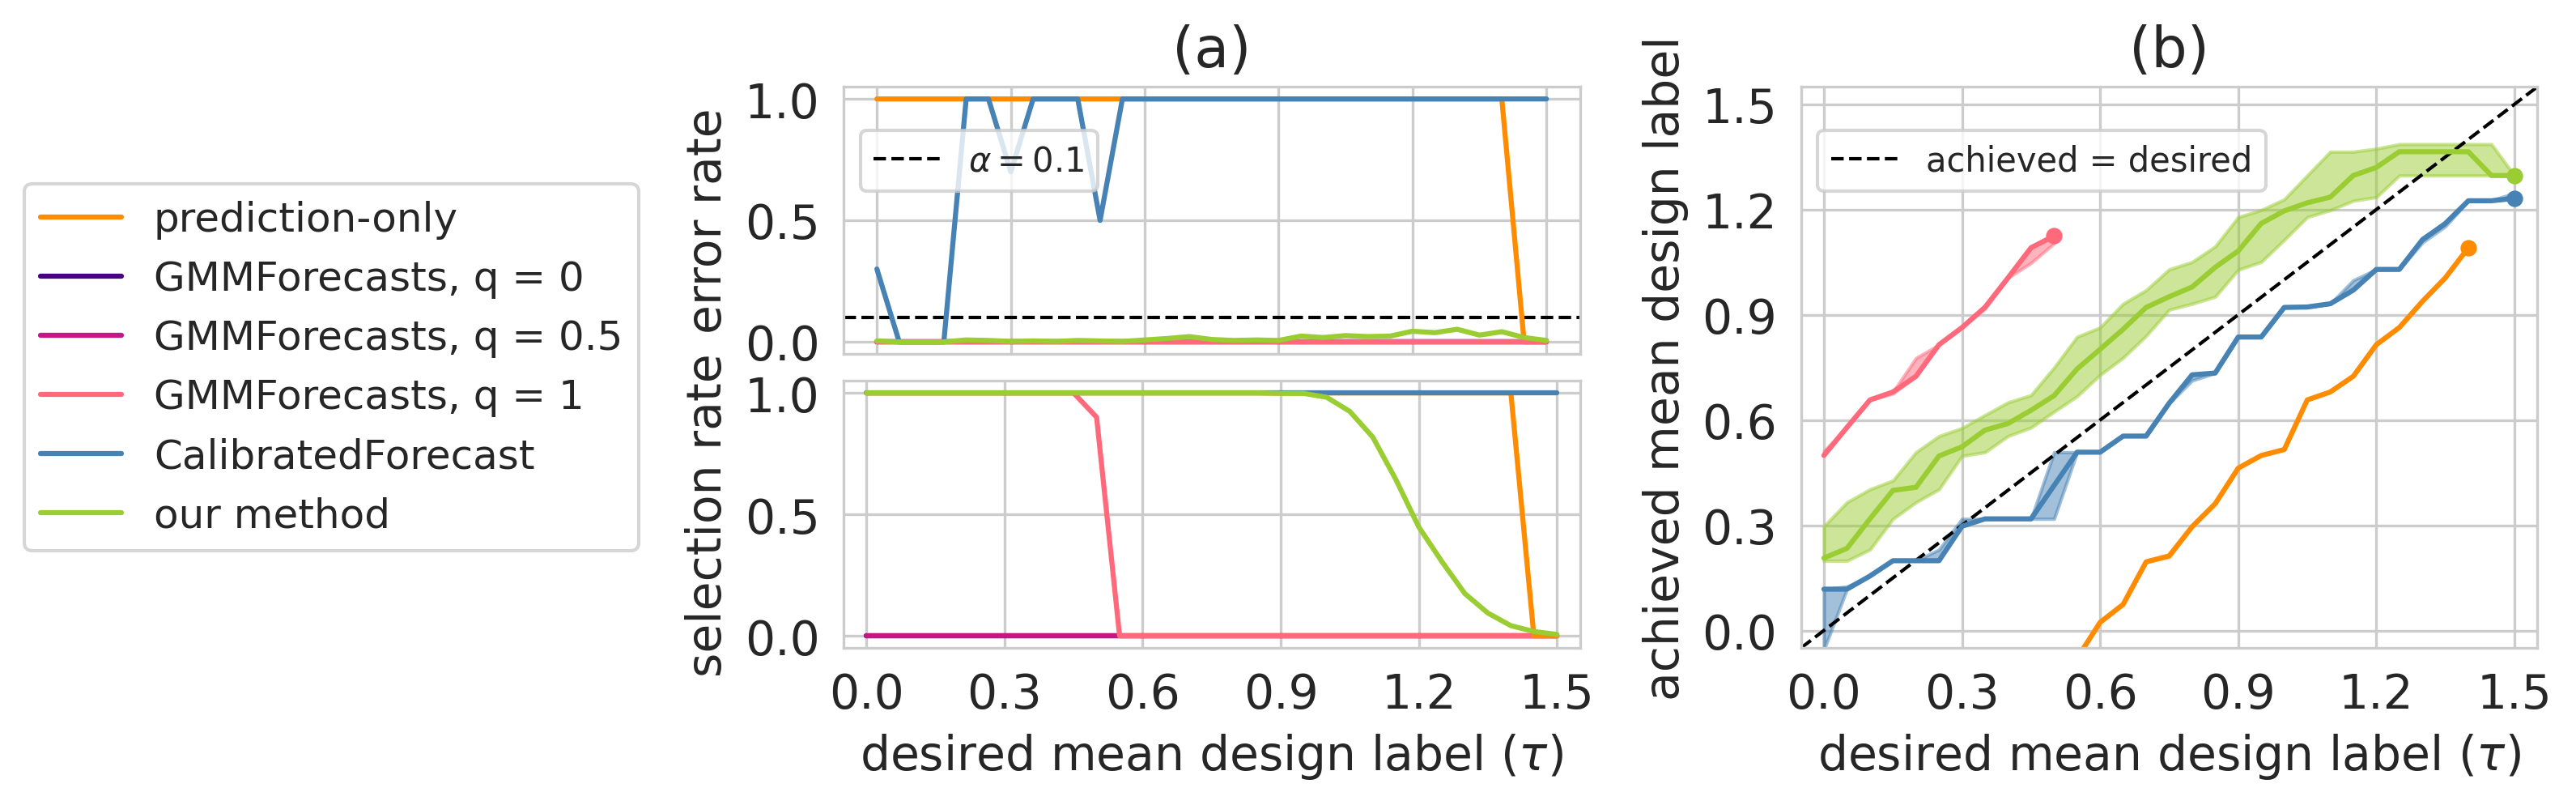

In [12]:
# one-row figure
sns.set_style('whitegrid')
fig = plt.figure(figsize=(9, 3), dpi=300)

gs = gridspec.GridSpec(1, 2, figure=fig)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])

ax1 = fig.add_subplot(gs[1])
ax00 = fig.add_subplot(gs0[0])
ax10 = fig.add_subplot(gs0[1])

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.1)

alpha = 0.1
gmm_type = 'cs'
po_color = 'darkorange'
pp_color = 'yellowgreen'
gmm_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'k'

lw = 1.5
dark_lw = 1
legend_fs = 12
err_lim = [-0.05, 1.05]
err_ticks = [0, 0.5, 1]
tau_lim = [-0.05, 1.55]
tau_ticks = np.arange(0, 1.55, 0.3)
marker_sz = 15

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====

# ----- top (error) -----
ax00.axhline(alpha, linestyle='--', color=dark_line_color, alpha=1, linewidth=dark_lw, label=r'$\alpha = {}$'.format(alpha));

ax00.plot(desired_values, poerr_v, c=po_color, linewidth=lw);
for q_idx, q in enumerate(DEFAULT_GMM_QS):
    gmmerr_v, gmmsel_v, gmmworst_v = q2gmmresults[q]
    ax00.plot(desired_values, gmmerr_v, c=gmm_colors[q_idx], linewidth=lw);  # top subplot
    ax10.plot(desired_values, gmmsel_v, '-', c=gmm_colors[q_idx], linewidth=lw);  # bottom subplot
ax00.plot(desired_values, calerr_v, c='steelblue', linewidth=lw);
ax00.plot(desired_values, pperr_v, c=pp_color, linewidth=lw);

ax00.set_yticks(err_ticks)
ax00.set_ylim(err_lim)
ax00.set_xticks(tau_ticks)
ax00.set_xticklabels([])
ax00.set_ylabel('error rate');
ax00.set_title('(a)');
ax00.legend(fontsize=10, loc='upper left', bbox_to_anchor=(0, 0.9));


# ----- bottom (selection rate) -----
ax10.plot(desired_values, posel_v, '-', c=po_color, linewidth=lw);
ax10.plot(desired_values, calsel_v, '-', c='steelblue', linewidth=lw);
ax10.plot(desired_values, ppsel_v, '-', c=pp_color, linewidth=lw);

# dummy plot to get legend for subplot (b)
ax10.plot([-1, -1], [-1, -1], '--', c=dark_line_color, linewidth=dark_lw, label='achieved = desired')
ax10.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.3, 2));

ax10.set_xlim(tau_lim)
ax10.set_ylim(err_lim)
ax10.set_xticks(tau_ticks)
ax10.set_yticks(err_ticks)
ax10.set_ylabel('selection rate');
ax10.set_xlabel(r'desired mean design label ($\tau$)');


# ===== subplot (b) =====

ax1.plot(tau_lim, tau_lim, '--', c=dark_line_color, alpha=1, linewidth=dark_lw);
median_v = [np.median(worst) if len(worst) else np.nan for worst in poworst_v]
ax1.plot(
    desired_values, median_v,
    c=po_color, label='prediction-only', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(desired_values[last_idx], median_v[last_idx], c=po_color, s=marker_sz, alpha=1)
ax1.fill_between(
    desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in poworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in poworst_v],
    color=po_color, alpha=0.5,
)

for q_idx, q in enumerate(DEFAULT_GMM_QS):
    gmmerr_v, gmmsel_v, gmmworst_v = q2gmmresults[q]
    median_v = [np.median(worst) if len(worst) else np.nan for worst in gmmworst_v]
    ax1.plot(
        desired_values, median_v,
        c=gmm_colors[q_idx], label=f'GMMForecasts, q = {q}', linewidth=lw,
    )
    last_idx = np.where(np.isnan(median_v))[0][0] - 1
    ax1.scatter(desired_values[last_idx], median_v[last_idx], c=gmm_colors[q_idx], s=marker_sz, alpha=1)
    ax1.fill_between(
        desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in gmmworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in gmmworst_v],
        color=gmm_colors[q_idx], alpha=0.5,
    )

median_v = [np.median(worst) if len(worst) else np.nan for worst in calworst_v]    
ax1.plot(
    desired_values, median_v,
    c='steelblue', label='CalibratedForecast', linewidth=lw,
)
last_idx = -1
ax1.scatter(desired_values[last_idx], median_v[last_idx], c='steelblue', s=marker_sz, alpha=1)
ax1.fill_between(
    desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in calworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in calworst_v],
    color='steelblue', alpha=0.5,
)

median_v = [np.median(worst) if len(worst) else np.nan for worst in ppworst_v]
ax1.plot(
    desired_values, median_v,
    c=pp_color, label='our method', linewidth=lw,
)
last_idx = -1
ax1.scatter(desired_values[last_idx], median_v[last_idx], c=pp_color, s=marker_sz, alpha=1)
ax1.fill_between(
    desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

ax1.set_xlim(tau_lim)
ax1.set_ylim(tau_lim)
ax1.set_xticks(tau_ticks)
ax1.set_yticks(tau_ticks)
ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.55, 0.5))

ax1.set_title('(b)')
ax1.set_ylabel('achieved mean design label');
ax1.set_xlabel(r'desired mean design label ($\tau$)');
